<a href="https://colab.research.google.com/github/aleena999/wbc_deepLearning/blob/main/CNN_WBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import zipfile
import os
!wget --no-check-certificate \
    "https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip" \
    -O "/tmp/WBC_images.zip"


zip_ref = zipfile.ZipFile('/tmp/WBC_images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-08-12 03:26:25--  https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main [following]
--2022-08-12 03:26:26--  https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/WBC_images.zip’

/tmp/WBC_images.zip     [         <=>        ]   1010M  17.7MB/s    in 63s     

2022-08-12 03:27:29 (16.1 MB/s) - ‘/tmp/WBC_images.zip’ saved [1059522558]



#Headers
NumPy for computation

plotly.express, matplotlib.pyplot, seaborn for visualization

tesnflow for training

sklearn.metrics for analyzing reports



In [34]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

In [35]:
train_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Train'
test_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Test'

#Loading Image Data
Generators will load them few at a time, train on them and recycle memory.

**tf.keras.preprocessing.image.ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation

**preprocessing_function:** The function will run after the image is resized and augmented. The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.

**validation_split:** Fraction of images reserved for validation (strictly between 0 and 1)

In [36]:
# Create generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [37]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


#Build Pretrained Model

In [38]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

#Build Classification Model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

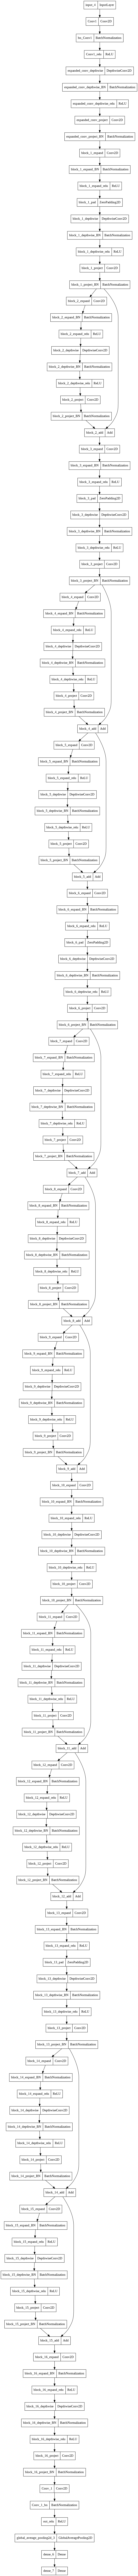

In [39]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())
tf.keras.utils.plot_model(
    model,
    to_file="model.png")

#Training

In [40]:
epochs = 25
stepsperepoch=100
validationsteps=1
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)

history = model.fit(
     train_images,
    epochs=epochs,
    callbacks=[annealer,es],
    steps_per_epoch=stepsperepoch,
    validation_data=val_images,
        )

Epoch 1/25
100/100 [==============================] - 31s 283ms/step - loss: 0.4238 - accuracy: 0.8700 - val_loss: 0.5512 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - 27s 275ms/step - loss: 0.2313 - accuracy: 0.9297 - val_loss: 0.5266 - val_accuracy: 0.8293 - lr: 9.5000e-04
Epoch 3/25
100/100 [==============================] - 27s 274ms/step - loss: 0.1776 - accuracy: 0.9388 - val_loss: 0.4773 - val_accuracy: 0.8455 - lr: 9.0250e-04
Epoch 4/25
100/100 [==============================] - 27s 272ms/step - loss: 0.1360 - accuracy: 0.9538 - val_loss: 0.4899 - val_accuracy: 0.8455 - lr: 8.5737e-04
Epoch 4: early stopping


#Results

In [41]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

In [42]:
preds = model.evaluate(train_images)
print ("Validation Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))

255/255 [==============================] - 43s 170ms/step - loss: 0.1212 - accuracy: 0.9622
Validation Loss = 0.12122167646884918
Validation Accuracy = 0.9621714353561401


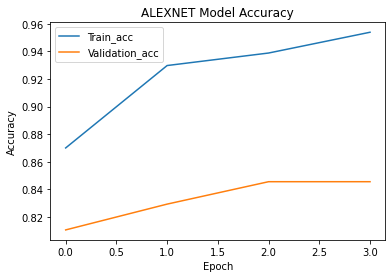

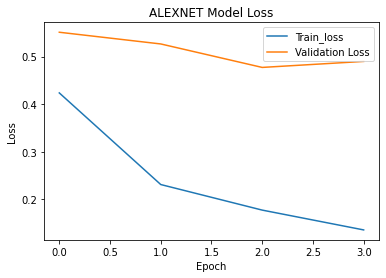

In [46]:
# Plotting Accuracy and Loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

In [47]:
predictions = np.argmax(model.predict(test_images), axis=1)
print(classification_report(test_images.labels, predictions, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00        89
  Eosinophil       0.64      0.88      0.74       322
  Lymphocyte       0.97      0.92      0.94      1034
    Monocyte       0.80      0.79      0.79       234
  Neutrophil       0.97      0.94      0.96      2660

    accuracy                           0.93      4339
   macro avg       0.88      0.91      0.89      4339
weighted avg       0.94      0.93      0.93      4339



Test Accuracy: 92.740%


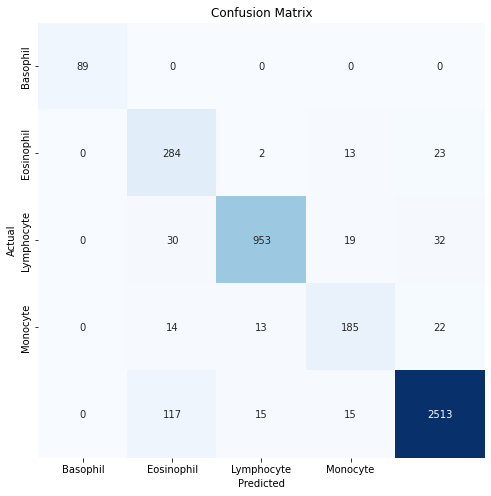

In [48]:
from sklearn.metrics import accuracy_score
import seaborn as sns
acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

SOURCE: class: Test, file: Basophil
0
PREDICTED: class: Monocyte, confidence: 0.722369


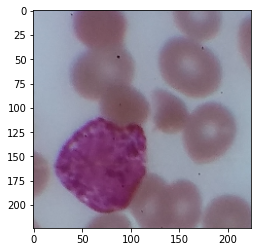

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Neutrophil
1
PREDICTED: class: Eosinophil, confidence: 0.696822


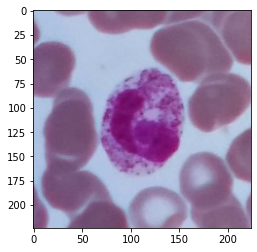

SOURCE: class: Test, file: Neutrophil
2
PREDICTED: class: Neutrophil, confidence: 0.694229


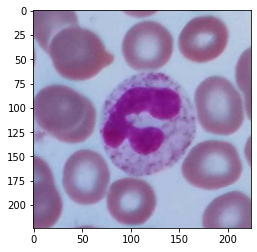

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Neutrophil
3
PREDICTED: class: Neutrophil, confidence: 0.915973


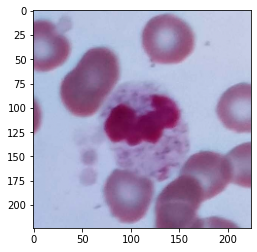

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Basophil
4
PREDICTED: class: Monocyte, confidence: 0.410926


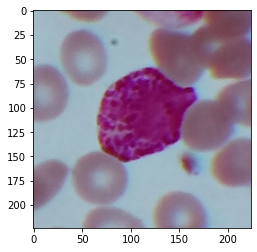

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Neutrophil
5
PREDICTED: class: Neutrophil, confidence: 0.964755


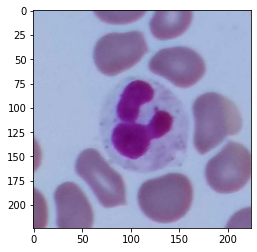

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Lymphocyte
6
PREDICTED: class: Neutrophil, confidence: 0.890364


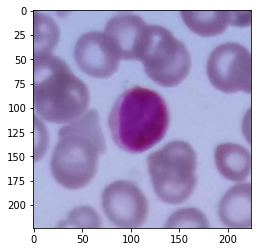

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Lymphocyte
7
PREDICTED: class: Neutrophil, confidence: 0.865336


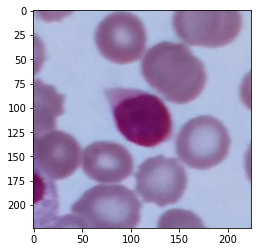

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Eosinophil
8
PREDICTED: class: Eosinophil, confidence: 0.479353


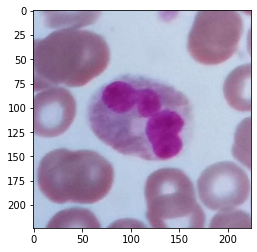

<Figure size 432x288 with 0 Axes>

SOURCE: class: Test, file: Neutrophil
9
PREDICTED: class: Neutrophil, confidence: 0.990486


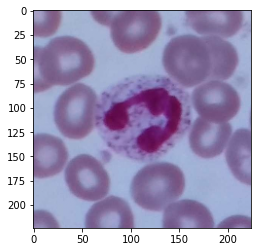

<Figure size 432x288 with 0 Axes>

In [49]:
# Utility
import itertools
import random
from collections import Counter
from glob import iglob
from imutils import paths
import cv2
import os



def load_image(filename):
    img = cv2.imread(os.path.join(test_dir, filename))
    img = cv2.resize(img, (224,224) )
    img = img /255
    
    return img

def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {CLASS_NAMES[class_idx]: probabilities[class_idx]}


for idx, filename in enumerate(random.sample(list(paths.list_images(test_dir)),10)):
    print("SOURCE: class: %s, file: %s" % (filename.split('/')[5], filename.split('/')[6]))
    print(idx)
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()